<a href="https://colab.research.google.com/github/SattuSupCodes/SentimentAnalysis_TheoreticalLearning/blob/main/ReadingDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are we doing

1. In this notebook, we will be looking into how we can upload and read our raw audio dataet and trn it into machine understandable format

2. Here we have used RAVDESS datasets (labelled)



In [28]:
import numpy as np #for the calculations
import librosa  #for speech analysis
import librosa.display as lpd #for display of analysis
import matplotlib.pyplot as plt #for plotting our model's outputs
import IPython.display as ipd #for display of images, audios etc (a stronger version of printf in a nutshell)
import pandas as pd #for datasets manipulation
import kagglehub #for working with kaggle
import os #for listdir
import zipfile #for zipfiled dataset extraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #for confusion matrix display



In [1]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#os.listdir('/content/drive/MyDrive')

In [ ]:
zip_path = '/content/drive/MyDrive/ravdess1.zip'
extract_path = '/content/drive/MyDrive/ravdess'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
#os.listdir('/content/drive/MyDrive/ravdess')


In [13]:
file_path = '/content/drive/MyDrive/ravdess/Actor_01/03-01-01-01-01-01-01.wav'
y, sr = librosa.load(file_path)

print(y.shape, sr)  #just checkin if its reading

(72838,) 22050


Our system is now reading our dataset!!

# What's Next?

AI cannot "listen" and make judgements, however it surely can read and calculate numbers and make computative analysis.

Voice is a wave, i.e., it can be presented in the form of frequency. This frequency can be vectorized and henceforth, can be read by our AI.

We use Fourier Transformers or Short-Time Fourier Transormers to convert our data to frequencies.

These give output in the form of Spectrograms.

In [15]:
stft = librosa.stft(y)
spectrogram = np.abs(stft)

print("Spectrogram shape:", spectrogram.shape)

Spectrogram shape: (1025, 143)


# MFCC: Mel-Frequency Cepstral Coefficients

A signal analysis and voice/speech processing technology.




In [14]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print("MFCC shape:", mfcc.shape)


MFCC shape: (13, 143)


# What Happened Here?

Our MFCC gave output as (how many distinct features, in how many frames)



In [8]:
KIND_EMOTIONS = ['01', '02', '03']
RUDE_EMOTIONS = ['05', '06', '07']

# What Are These Numbers?
RAVDESS uses numbers to categorise or label emotions.

01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

to keep these simple, we simply divided these in two categories - kind and rude. This is for baseline categorization and predictions.

In [16]:
def extract_features(file_path):
    y, sr = np.lib.load(file_path, sr=None)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) #rewrote this in a function. The above one is for demonstration purpose.

    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    features = np.concatenate([mfcc_mean, mfcc_std])
    return features

In [18]:
X = []
y = []

base_path = "/content/drive/MyDrive/ravdess"

for actor in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor)

    for file in os.listdir(actor_path):
        if not file.endswith(".wav"):
            continue

        emotion_code = file.split("-")[2] #most important part
        file_path = os.path.join(actor_path, file)

        if emotion_code in KIND_EMOTIONS:
            X.append(extract_features(file_path))
            y.append(0)

        elif emotion_code in RUDE_EMOTIONS:
            X.append(extract_features(file_path))
            y.append(1)


Above we took our data and split it.
the X array will store our feature vectors and the Y array will store whether the audio is kind (0) or rudee (1). Both array elements will correspond to each other.

Now the MOST IMPORTANT PART: RAVDESS files are stored in 03-01-06-01-02-01-12.wav (example) where index [2] -> emotion. This is how we extract the emotion feature from our audio file label.

In [19]:
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (1056, 26)
Labels shape: (1056,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [25]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [26]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7594339622641509
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        96
           1       0.77      0.79      0.78       116

    accuracy                           0.76       212
   macro avg       0.76      0.76      0.76       212
weighted avg       0.76      0.76      0.76       212



In [29]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[69 27]
 [24 92]]


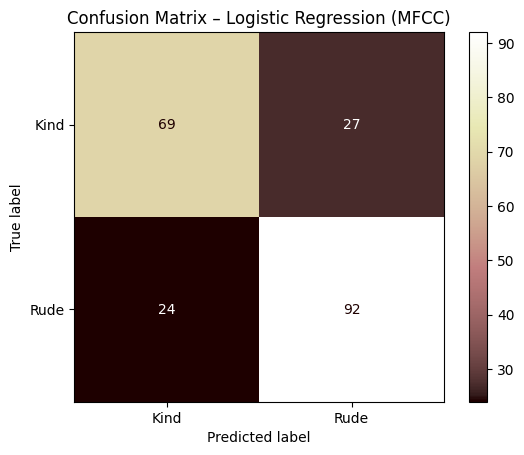

In [31]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Kind", "Rude"]
)

disp.plot(cmap="pink")
plt.title("Confusion Matrix – Logistic Regression (MFCC)")
plt.show()
